>### HW 9.0: Short answer questions

>What is PageRank and what is it used for in the context of web search?  
>What modifications have to be made to the webgraph in order to leverage the machinery of Markov Chains to 
compute the steady stade distibuton?  
OPTIONAL: In topic-specific pagerank, how can we insure that the irreducible property is satified? (HINT: see HW9.4)



>### HW 9.1: MRJob implementation of basic PageRank

>Write a basic MRJob implementation of the iterative PageRank algorithm
that takes sparse adjacency lists as input (as explored in HW 7).
Make sure that you implementation utilizes teleportation (1-damping/the number of nodes in the network), 
and further, distributes the mass of dangling nodes with each iteration
so that the output of each iteration is correctly normalized (sums to 1).
[NOTE: The PageRank algorithm assumes that a random surfer (walker), starting from a random web page,
chooses the next page to which it will move by clicking at random, with probability d,
one of the hyperlinks in the current page. This probability is represented by a so-called
‘damping factor’ d, where d ∈ (0, 1). Otherwise, with probability (1 − d), the surfer
jumps to any web page in the network. If a page is a dangling end, meaning it has no
outgoing hyperlinks, the random surfer selects an arbitrary web page from a uniform
distribution and “teleports” to that page]


>As you build your code, use the test data  

>s3://ucb-mids-mls-networks/PageRank-test.txt
Or under the Data Subfolder for HW7 on Dropbox with the same file name. 
(On Dropbox https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0)

>with teleportation parameter set to 0.15 (1-d, where d, the damping factor is set to 0.85), and crosscheck
your work with the true result, displayed in the first image
in the Wikipedia article:

>https://en.wikipedia.org/wiki/PageRank

>and here for reference are the corresponding PageRank probabilities:

>A,0.033  
B,0.384  
C,0.343  
D,0.039  
E,0.081  
F,0.039  
G,0.016  
H,0.016  
I,0.016  
J,0.016  
K,0.016  

In [148]:
%%writefile format_nodes.py
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import JSONProtocol, RawProtocol

class FormatNodes(MRJob):
    OUTPUT_PROTOCOL = JSONProtocol
    INPUT_PROTOCOL = RawProtocol
    
    def configure_options(self):
        super(FormatNodes, self).configure_options()
        self.add_passthrough_option(
            '--summary-file', dest='summary_file', default='summary.txt',
            help='file to store summary data')
    
    def mapper(self, node_id, links):
        ''' Re-format links '''
        links = eval(links)
        node = {}
        if links is not None:
            node['links'] = sorted(links.items())
        else:
            node['links'] = []

        node['score'] = 1
        for link, score in node['links']:
            yield link, {'score':0,'links':[]}
        
        yield node_id, node
    
    def reducer_init(self):
        ''' Initialize N count '''
        self.total_count = 0
    
    def reducer(self, node_id, nodelist):
        ''' Compile all nodes '''
        self.total_count += 1
        links = []
        score = 0
        for node in nodelist:
            node_links = node['links']
            for l in node_links:
                links.append(l)
            score = sum([score, node['score']])
        yield node_id, {'score':max(score,1),'links':links}
        
    def reducer_final(self):
        ''' Output N to file '''
        with open(self.options.summary_file,'a') as w:
            w.write(str(self.total_count)+'\n')

if __name__ == '__main__':
    FormatNodes.run()

Overwriting format_nodes.py


In [202]:
%%writefile mrpagerank.py
from mrjob.job import MRJob
from mrjob.protocol import JSONProtocol
from mrjob.step import MRStep

class MRPageRank(MRJob):
    
    INPUT_PROTOCOL = JSONProtocol  # read the same format we write
    OUTPUT_PROTOCOL = JSONProtocol
    
    def configure_options(self):
        super(MRPageRank, self).configure_options()
        
        self.add_passthrough_option(
            '--iterations', dest='iterations', default=10, type='int',
            help='number of iterations to run')

        self.add_passthrough_option(
            '--damping-factor', dest='damping_factor', default=0.85,
            type='float',
            help='probability a web surfer will continue clicking on links')
        
        self.add_passthrough_option(
            '--summary-file', dest='summary_file', default='summary.txt',
            help='file to store summary data')
        
        self.add_passthrough_option(
            '--node-count', dest='node_count', type='int',
            help='number of nodes')
    
    def initialize_n(self):
        ''' Count number of nodes 
            from some summary file
        '''
        if not self.options.node_count:
            try:
                with open(self.options.summary_file,'r') as r:
                    counts = [ int(l.strip()) for l in r.readlines() ]
                    self.node_count = sum(counts)
            except IOError:
                self.node_count = 1
        else:
            self.node_count = self.options.node_count
    
    def send_score(self, node_id, node):
        """Mapper: send score from a single node to other nodes.
        Input: ``node_id, node``
        Output:
        ``node_id, ('node', node)`` OR
        ``node_id, ('score', score)``
        """
        # send node as-is
        yield node_id, ('node', node)
        
        # check number of links
        link_len = len(node.get('links'))
        
        # check for dangling node 
        if link_len==0:
            # send dangling node to counter 
            yield '*', node['score']   
        
        # send node scores for linked nodes 
        for dest_id, weight in node.get('links') or []:
            yield dest_id, ('score', node['score'] / link_len * weight)
    
    def score_init(self):
        ''' initialize dangling nodes counter '''
        self.dangling_nodes = 0
    
    def receive_score(self, node_id, typed_values):
        """Reducer: Combine scores sent from other nodes, and update this node
        (creating it if necessary).
        Store information about the node's previous score in *prev_score*.
        """
        node = {}
        total_score = 0
        
        if node_id == '*':
            self.dangling_nodes = sum(typed_values)
        else:
            for value_type, value in typed_values:
                if value_type == 'node':
                    node = value
                else:
                    assert value_type == 'score'
                    total_score += value

            node['prev_score'] = node['score']

            d = self.options.damping_factor
            n = self.node_count 
            m = self.dangling_nodes 
            node['score'] = (1 - d)/n + d * ( total_score + m / n )

            yield node_id, node
    
    def steps(self):
        return ([MRStep(mapper=self.send_score
                       , reducer=self.receive_score
                       , reducer_init=self.initialize_n
                       , jobconf={
                            'mapred.reduce.tasks': 1
                        })] *
                self.options.iterations)

if __name__ == '__main__':
    MRPageRank.run()

Overwriting mrpagerank.py


In [203]:
!head ./Data/PageRank-test.txt

B	{'C': 1}
C	{'B': 1}
D	{'A': 1, 'B': 1}
E	{'D': 1, 'B': 1, 'F': 1}
F	{'B': 1, 'E': 1}
G	{'B': 1, 'E': 1}
H	{'B': 1, 'E': 1}
I	{'B': 1, 'E': 1}
J	{'E': 1}
K	{'E': 1}


In [204]:
!rm summary.txt
!python format_nodes.py \
--summary-file=/Users/bshur/School/ML\ at\ Scale/HW9/summary.txt ./Data/PageRank-test.txt \
> ./pg_formatted.json \
2>/dev/null

In [205]:
cat ./pg_formatted.json

"A"	{"score": 1, "links": []}
"B"	{"score": 1, "links": [["C", 1]]}
"C"	{"score": 1, "links": [["B", 1]]}
"D"	{"score": 1, "links": [["A", 1], ["B", 1]]}
"E"	{"score": 1, "links": [["B", 1], ["D", 1], ["F", 1]]}
"F"	{"score": 1, "links": [["B", 1], ["E", 1]]}
"G"	{"score": 1, "links": [["B", 1], ["E", 1]]}
"H"	{"score": 1, "links": [["B", 1], ["E", 1]]}
"I"	{"score": 1, "links": [["B", 1], ["E", 1]]}
"J"	{"score": 1, "links": [["E", 1]]}
"K"	{"score": 1, "links": [["E", 1]]}


In [206]:
!cat summary.txt

11


In [209]:
!python mrpagerank.py \
--summary-file=/Users/bshur/School/ML\ at\ Scale/HW9/summary.txt \
--iterations=50 pg_formatted.json \
> pg_scores.txt \
2> /dev/null

In [210]:
!cat pg_scores.txt

"A"	{"score": 0.03278149315936145, "prev_score": 0.03278149315937677, "links": []}
"B"	{"score": 0.384833778728028, "prev_score": 0.384935612433039, "links": [["C", 1]]}
"C"	{"score": 0.34336474958494406, "prev_score": 0.34341949717240156, "links": [["B", 1]]}
"D"	{"score": 0.03908709209998528, "prev_score": 0.039087092100001206, "links": [["A", 1], ["B", 1]]}
"E"	{"score": 0.08088569323452899, "prev_score": 0.08088569323455651, "links": [["B", 1], ["D", 1], ["F", 1]]}
"F"	{"score": 0.03908709209998528, "prev_score": 0.039087092100001206, "links": [["B", 1], ["E", 1]]}
"G"	{"score": 0.016169479016860937, "prev_score": 0.016169479016863043, "links": [["B", 1], ["E", 1]]}
"H"	{"score": 0.016169479016860937, "prev_score": 0.016169479016863043, "links": [["B", 1], ["E", 1]]}
"I"	{"score": 0.016169479016860937, "prev_score": 0.016169479016863043, "links": [["B", 1], ["E", 1]]}
"J"	{"score": 0.016169479016860937, "prev_score": 0.016169479016863043, "links": [["E", 1]]}
"K"	{"score": 0.016169

>### HW 9.2: Exploring PageRank teleportation and network plots
>In order to overcome  problems such as disconnected components, the damping factor (a typical value for d is 0.85) can be varied.   
>Using the graph in HW1, plot the test graph (using networkx, https://networkx.github.io/) for several values of the damping parameter alpha,
so that each nodes radius is proportional to its PageRank score. In particular you should
do this for the following damping factors: [0,0.25,0.5,0.75, 0.85, 1]. 

>Note your plots should look like the following:  
>https://en.wikipedia.org/wiki/PageRank#/media/File:PageRanks-Example.svg


In [305]:
%%writefile format_pg_scores.py
from mrjob.job import MRJob
from mrjob.protocol import JSONProtocol
from mrjob.step import MRStep

class FormatPGScores(MRJob):
    INPUT_PROTOCOL = JSONProtocol  # read the same format we write
    OUTPUT_PROTOCOL = JSONProtocol
    
    def mapper(self, node_id, node):
        ''' extract node links and 
            interate through in networkx format 
        '''
        links = node['links']
        for link, _ in links:
            yield node_id, link

if __name__=='__main__':
    FormatPGScores.run()

Overwriting format_pg_scores.py


In [306]:
!head pg_scores.txt

"A"	{"score": 0.03278149315936145, "prev_score": 0.03278149315937677, "links": []}
"B"	{"score": 0.384833778728028, "prev_score": 0.384935612433039, "links": [["C", 1]]}
"C"	{"score": 0.34336474958494406, "prev_score": 0.34341949717240156, "links": [["B", 1]]}
"D"	{"score": 0.03908709209998528, "prev_score": 0.039087092100001206, "links": [["A", 1], ["B", 1]]}
"E"	{"score": 0.08088569323452899, "prev_score": 0.08088569323455651, "links": [["B", 1], ["D", 1], ["F", 1]]}
"F"	{"score": 0.03908709209998528, "prev_score": 0.039087092100001206, "links": [["B", 1], ["E", 1]]}
"G"	{"score": 0.016169479016860937, "prev_score": 0.016169479016863043, "links": [["B", 1], ["E", 1]]}
"H"	{"score": 0.016169479016860937, "prev_score": 0.016169479016863043, "links": [["B", 1], ["E", 1]]}
"I"	{"score": 0.016169479016860937, "prev_score": 0.016169479016863043, "links": [["B", 1], ["E", 1]]}
"J"	{"score": 0.016169479016860937, "prev_score": 0.016169479016863043, "links": [["E", 1]]}


In [307]:
!python format_pg_scores.py pg_scores.txt > pg_scores_formatted.txt 2> /dev/null

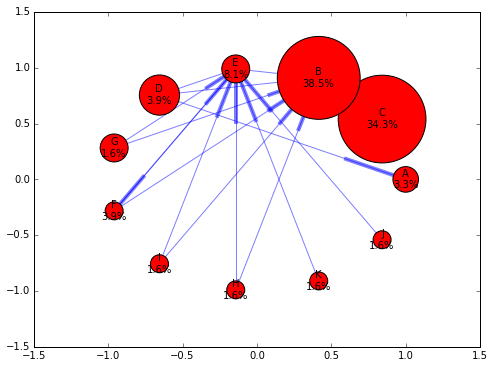

In [337]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
%matplotlib inline 
pylab.rcParams['figure.figsize'] = (8.0, 6.0)

# Get edges 
with open('pg_scores_formatted.txt','r') as r:
    lines = [ l.strip().split('\t') for l in r.readlines() ] 
    edges = [ (eval(f), eval(t)) for f,t in lines  ]

# Get node sizes
with open('pg_scores.txt','r') as r:
    lines = [ l.strip().split('\t') for l in r.readlines() ] 
    node_weights = sorted([ (eval(l[0]),eval(l[1])['score']) for l in lines ])
    
# Create directed graph
G=nx.DiGraph()
G.add_edges_from(edges)
for edge in edges:
    f, t = edge
    G[f][t]['node_id'] = f
    G[f][t]['to_node'] = t

# get layout
pos=nx.shell_layout(G)

# nodes
nx.draw_networkx_nodes(G,pos,node_size=[ n[1]*20000 for n in node_weights])

# labels
nx.draw_networkx_labels(G,pos
                        ,labels={n[0]: '{}\n{}%'.format(n[0],round(n[1]*100,1)) for n in node_weights} 
                        ,font_size=10, font_family='sans-serif')

# edges
nx.draw_networkx_edges(G,pos,width=1,alpha=0.5,edge_color='b')

plt.show()